<a href="https://colab.research.google.com/github/thegith45/Decentralized-learning/blob/main/FedProx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FEDAVG Round 1/20 - Train Acc: 30.27% | Val Acc: 17.00%
FEDAVG Round 2/20 - Train Acc: 36.70% | Val Acc: 19.56%
FEDAVG Round 3/20 - Train Acc: 38.94% | Val Acc: 21.58%
FEDAVG Round 4/20 - Train Acc: 55.81% | Val Acc: 39.70%
FEDAVG Round 5/20 - Train Acc: 64.65% | Val Acc: 48.20%
FEDAVG Round 6/20 - Train Acc: 72.37% | Val Acc: 55.98%
FEDAVG Round 7/20 - Train Acc: 77.13% | Val Acc: 60.52%
FEDAVG Round 8/20 - Train Acc: 79.95% | Val Acc: 62.86%
FEDAVG Round 9/20 - Train Acc: 80.16% | Val Acc: 63.62%
FEDAVG Round 10/20 - Train Acc: 83.58% | Val Acc: 65.56%
FEDAVG Round 11/20 - Train Acc: 84.30% | Val Acc: 67.10%
FEDAVG Round 12/20 - Train Acc: 84.02% | Val Acc: 66.62%
FEDAVG Round 13/20 - Train Acc: 87.28% | Val Acc: 69.04%
FEDAVG Round 14/20 - Train Acc: 84.67% | Val Acc: 66.46%
FEDAVG Round 15/20 - Train Acc: 87.32% | Val Acc: 69.20%
FEDAVG Round 16/20 - Train Acc: 87.50% | Val Acc: 69.44%
FEDAVG Round 17/20 - Train Acc: 87.60% | Val Acc: 69.44%
FEDAVG Round 18/20 - Train Acc: 87.92% |

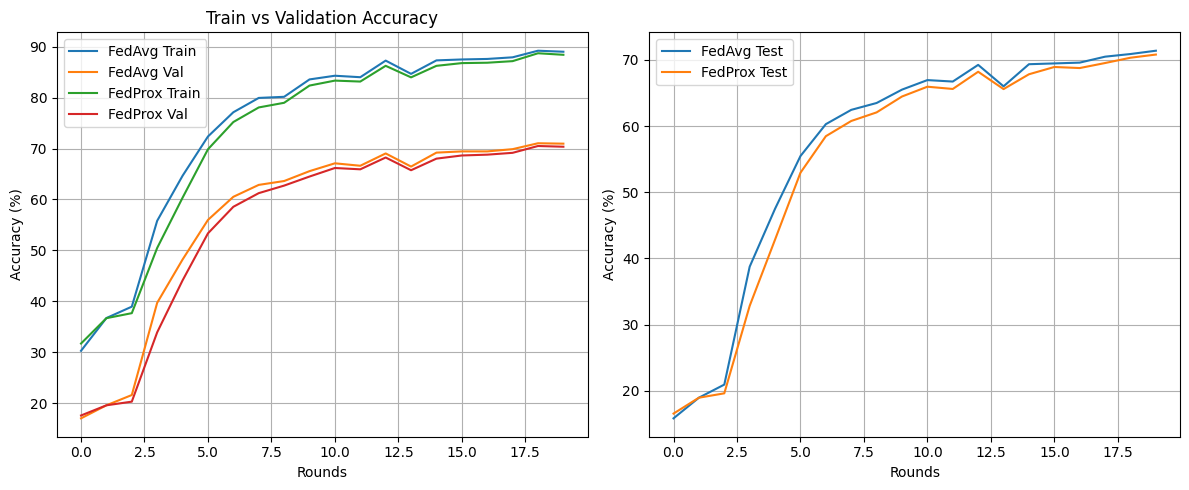

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import random
import matplotlib.pyplot as plt

# 1. Load MNIST
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return trainset, testset

# 2. Non-IID Partition
# Each client gets only two digits

def make_noniid_by_label(dataset, num_clients=10, num_labels_per_client=2):
    labels = np.array(dataset.targets)
    indices = np.arange(len(dataset))
    client_indices = [[] for _ in range(num_clients)]

    label_indices = {l: np.where(labels == l)[0] for l in range(10)}
    for l in label_indices:
        np.random.shuffle(label_indices[l])

    for client in range(num_clients):
        chosen_labels = np.random.choice(range(10), num_labels_per_client, replace=False)
        for l in chosen_labels:
            part = int(len(label_indices[l]) / num_clients)
            client_indices[client].extend(label_indices[l][:part])
            label_indices[l] = label_indices[l][part:]
    return client_indices

# 3. CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)

# 4. Client Class (FedAvg & FedProx)
class Client:
    def __init__(self, global_model, indices, device, dataset, batch_size=32):
        self.device = device
        self.model = CNN().to(device)
        self.model.load_state_dict(global_model.state_dict())
        self.loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True)

    def local_train(self, global_weights, epochs=1, lr=0.01, mu=0.1, use_fedprox=False):
        optimizer = optim.SGD(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        global_params = {k: v.clone().detach() for k, v in global_weights.items()}

        self.model.train()
        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)

                if use_fedprox:
                    prox_reg = 0.0
                    for name, param in self.model.named_parameters():
                        prox_reg += ((param - global_params[name])**2).sum()
                    loss += (mu/2) * prox_reg

                loss.backward()
                optimizer.step()

        return self.model.state_dict()

# 5. Federated Averaging
def fedavg(local_states):
    new_state = {}
    for k in local_states[0].keys():
        new_state[k] = sum(state[k] for state in local_states) / len(local_states)
    return new_state

# 6. Evaluation
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

# 7. Main Training Loop
def run_federated(num_clients=5, rounds=10, local_epochs=1, lr=0.01, mu=0.1,
                  algorithm='fedprox', batch_size=32, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainset, testset = load_mnist()

    client_idx_lists = make_noniid_by_label(trainset, num_clients)

    # Split validation set from test set
    val_size = len(testset) // 2
    valset, testset_real = torch.utils.data.random_split(testset, [val_size, len(testset) - val_size])
    val_loader = DataLoader(valset, batch_size=256, shuffle=False)
    test_loader = DataLoader(testset_real, batch_size=256, shuffle=False)

    global_model = CNN().to(device)

    history = {"train": [], "val": [], "test": []}
    for r in range(rounds):
        local_states = []
        client_train_loaders = []

        for i in range(num_clients):
            client = Client(global_model, client_idx_lists[i], device, trainset, batch_size=batch_size)
            client_train_loaders.append(client.loader)
            use_fedprox = (algorithm.lower() == 'fedprox')
            local_w = client.local_train(global_model.state_dict(), epochs=local_epochs, lr=lr,
                                         mu=mu, use_fedprox=use_fedprox)
            local_states.append(local_w)

        # aggregate
        new_global = fedavg(local_states)
        global_model.load_state_dict(new_global)

        # evaluate train acc
        train_accs = []
        for loader in client_train_loaders:
            acc = evaluate(global_model, loader, device)
            train_accs.append(acc)
        train_acc = np.mean(train_accs)

        val_acc = evaluate(global_model, val_loader, device)
        test_acc = evaluate(global_model, test_loader, device)

        history["train"].append(train_acc)
        history["val"].append(val_acc)
        history["test"].append(test_acc)

        print(f"{algorithm.upper()} Round {r+1}/{rounds} - "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return history

# -----------------------------
# 8. Run FedAvg and FedProx
# -----------------------------
fedavg_hist = run_federated(num_clients=5, rounds=20, local_epochs=2, lr=0.01, mu=0.1, algorithm='fedavg')
fedprox_hist = run_federated(num_clients=5, rounds=20, local_epochs=2, lr=0.01, mu=0.1, algorithm='fedprox')

# 9. Plot Results
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fedavg_hist["train"], label='FedAvg Train')
plt.plot(fedavg_hist["val"], label='FedAvg Val')
plt.plot(fedprox_hist["train"], label='FedProx Train')
plt.plot(fedprox_hist["val"], label='FedProx Val')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(fedavg_hist["test"], label='FedAvg Test')
plt.plot(fedprox_hist["test"], label='FedProx Test')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
#plt.title("Test Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [14]:
# -----------------------------
# 7. Main Training Loop
# -----------------------------
def run_federated(num_clients=5, rounds=10, local_epochs=1, lr=0.01, mu=0.1,
                  algorithm='fedprox', batch_size=32, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainset, testset = load_mnist()

    client_idx_lists = make_noniid_by_label(trainset, num_clients)

    # Split validation set from test set
    val_size = len(testset) // 2
    valset, testset_real = torch.utils.data.random_split(testset, [val_size, len(testset) - val_size])
    val_loader = DataLoader(valset, batch_size=256, shuffle=False)
    test_loader = DataLoader(testset_real, batch_size=256, shuffle=False)

    global_model = CNN().to(device)

    history = {"train": [], "val": [], "test": []}
    for r in range(rounds):
        local_states = []
        client_train_loaders = []

        for i in range(num_clients):
            client = Client(global_model, client_idx_lists[i], device, trainset, batch_size=batch_size)
            client_train_loaders.append(client.loader)
            use_fedprox = (algorithm.lower() == 'fedprox')
            local_w = client.local_train(global_model.state_dict(), epochs=local_epochs, lr=lr,
                                         mu=mu, use_fedprox=use_fedprox)
            local_states.append(local_w)

        # aggregate
        new_global = fedavg(local_states)
        global_model.load_state_dict(new_global)

        # evaluate train acc
        train_accs = []
        for loader in client_train_loaders:
            acc = evaluate(global_model, loader, device)
            train_accs.append(acc)
        train_acc = np.mean(train_accs)

        val_acc = evaluate(global_model, val_loader, device)
        test_acc = evaluate(global_model, test_loader, device)

        history["train"].append(train_acc)
        history["val"].append(val_acc)
        history["test"].append(test_acc)

        print(f"{algorithm.upper()} Round {r+1}/{rounds} - "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    return history, global_model, test_loader, device


In [15]:
# Train both algorithms
fedavg_hist, fedavg_model, test_loader, device = run_federated(algorithm='fedavg')
fedprox_hist, fedprox_model, _, _ = run_federated(algorithm='fedprox')


FEDAVG Round 1/10 - Train Acc: 19.77% | Val Acc: 11.14% | Test Acc: 9.94%
FEDAVG Round 2/10 - Train Acc: 36.43% | Val Acc: 19.40% | Test Acc: 18.92%
FEDAVG Round 3/10 - Train Acc: 36.49% | Val Acc: 19.72% | Test Acc: 19.00%
FEDAVG Round 4/10 - Train Acc: 45.25% | Val Acc: 28.10% | Test Acc: 27.66%
FEDAVG Round 5/10 - Train Acc: 56.57% | Val Acc: 40.10% | Test Acc: 39.36%
FEDAVG Round 6/10 - Train Acc: 66.50% | Val Acc: 50.10% | Test Acc: 50.06%
FEDAVG Round 7/10 - Train Acc: 69.46% | Val Acc: 53.44% | Test Acc: 52.78%
FEDAVG Round 8/10 - Train Acc: 74.38% | Val Acc: 58.44% | Test Acc: 58.36%
FEDAVG Round 9/10 - Train Acc: 76.75% | Val Acc: 60.04% | Test Acc: 59.56%
FEDAVG Round 10/10 - Train Acc: 78.57% | Val Acc: 62.00% | Test Acc: 61.72%
FEDPROX Round 1/10 - Train Acc: 19.63% | Val Acc: 11.06% | Test Acc: 9.80%
FEDPROX Round 2/10 - Train Acc: 36.43% | Val Acc: 19.42% | Test Acc: 18.92%
FEDPROX Round 3/10 - Train Acc: 36.48% | Val Acc: 19.72% | Test Acc: 18.92%
FEDPROX Round 4/10 - Tr

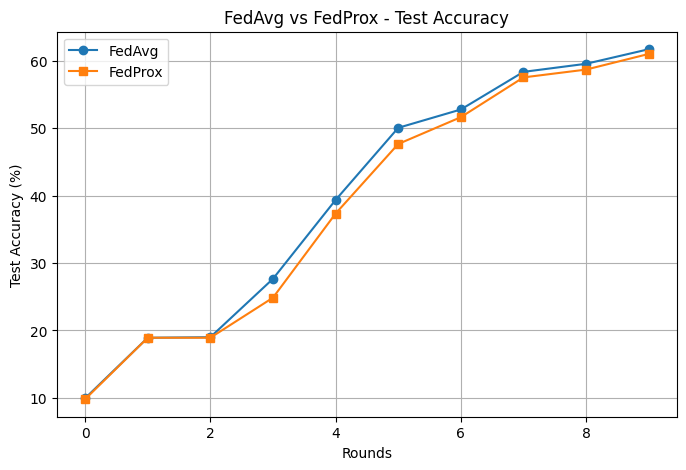

In [18]:

plt.figure(figsize=(8,5))
plt.plot(fedavg_hist["test"], label="FedAvg", marker='o')
plt.plot(fedprox_hist["test"], label="FedProx", marker='s')
plt.xlabel("Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("FedAvg vs FedProx - Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import classification_report

def print_classification_report(model, loader, device, name="Model"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

# Reports
print_classification_report(fedavg_model, test_loader, device, "FedAvg")
print_classification_report(fedprox_model, test_loader, device, "FedProx")



FedAvg Classification Report:
              precision    recall  f1-score   support

           0     0.8680    0.8713    0.8696       513
           1     0.9134    0.9472    0.9300       568
           2     0.8456    0.6255    0.7191       534
           3     0.4357    0.9470    0.5968       472
           4     0.0000    0.0000    0.0000       489
           5     0.9732    0.2370    0.3811       460
           6     0.8738    0.7892    0.8294       465
           7     0.9385    0.7193    0.8144       488
           8     0.0000    0.0000    0.0000       489
           9     0.3142    0.9444    0.4715       522

    accuracy                         0.6172      5000
   macro avg     0.6162    0.6081    0.5612      5000
weighted avg     0.6195    0.6172    0.5689      5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



FedProx Classification Report:
              precision    recall  f1-score   support

           0     0.8708    0.8538    0.8622       513
           1     0.9225    0.9437    0.9330       568
           2     0.8475    0.6142    0.7123       534
           3     0.4259    0.9492    0.5879       472
           4     0.0000    0.0000    0.0000       489
           5     0.9714    0.2217    0.3611       460
           6     0.8783    0.7763    0.8242       465
           7     0.9401    0.7070    0.8070       488
           8     0.0000    0.0000    0.0000       489
           9     0.3093    0.9444    0.4660       522

    accuracy                         0.6102      5000
   macro avg     0.6166    0.6010    0.5554      5000
weighted avg     0.6200    0.6102    0.5633      5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
